In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sb
from sklearn import metrics
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import math

from keras.callbacks import ModelCheckpoint, CSVLogger


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda, Embedding, LSTM, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K

import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from collections import Counter
from nltk.stem.porter import *

!pip freeze > requirements.txt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Reviews.csv")

In [ ]:
data.shape

(568454, 10)

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
data_copy = data.copy()

In [ ]:
data_copy = data_copy.drop(["Id","UserId","Time", "HelpfulnessNumerator", "HelpfulnessDenominator", "ProfileName"], axis=1)
data_copy.head()

,ProductId,Score,Summary,Text
0,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,5,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  568454 non-null  object
 1   Score      568454 non-null  int64 
 2   Summary    568427 non-null  object
 3   Text       568454 non-null  object
dtypes: int64(1), object(3)
memory usage: 17.3+ MB


In [ ]:
data_copy = data_copy.dropna(subset=["Score"])
data_copy["Score"] = data_copy["Score"].astype(int)

In [ ]:
data_copy["Score"].unique()

array([5, 1, 4, 2, 3])

## Exploratory Data Analysis

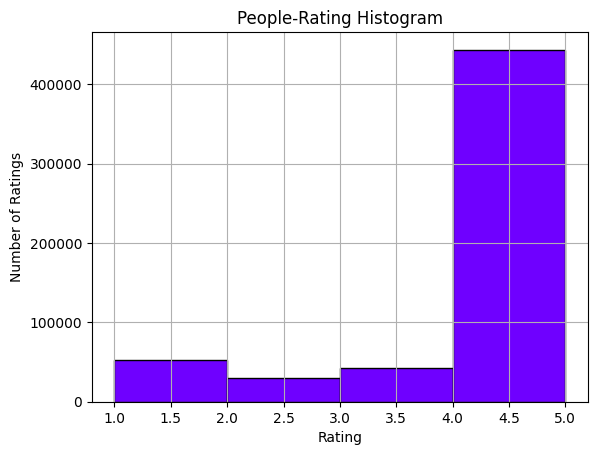

In [ ]:
import matplotlib.pyplot as plt


ratings = data_copy['Score']


plt.hist(ratings, bins=[1,2,3,4, 5], color="#6f00ff", edgecolor="black")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.title("People-Rating Histogram")
plt.grid(True)
plt.show()

In [ ]:
def clean_data(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub(r'[^a-zA-z0-9\s]','',text)
    return text

In [ ]:
data_copy['Text']=data_copy['Text'].apply(clean_data)

<ipython-input-13-1c6dd617fd58>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
data_copy.head()

,ProductId,Score,Summary,Text
0,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,5,Great taffy,Great taffy at a great price There was a wide...


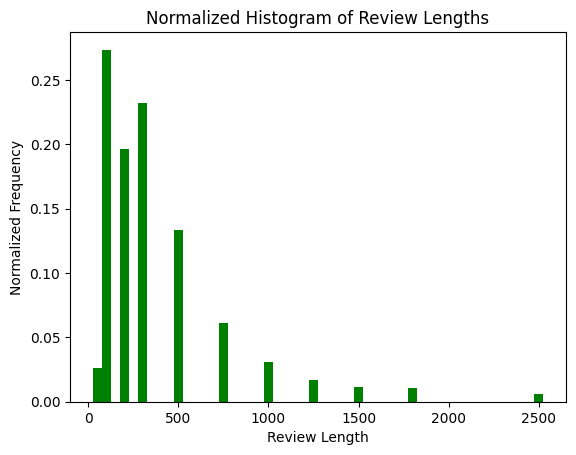

In [ ]:

review_lengths = data['Text'].str.len()


bin_edges = [50, 100, 200, 300, 500, 750, 1000, 1250, 1500, 1800, 2500, 5000]


hist, _ = np.histogram(review_lengths, bins=bin_edges)
freq = hist / len(review_lengths)


plt.bar(bin_edges[:-1], freq, width=50,color ='green')
plt.xlabel('Review Length')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Histogram of Review Lengths')
plt.show()


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
from nltk.corpus import stopwords


#nltk.download()


stop = set(stopwords.words('english'))
stopword_list = list(stop)
stopword_list.sort()


Text(0.5, 1.0, 'Histogram of stop words')

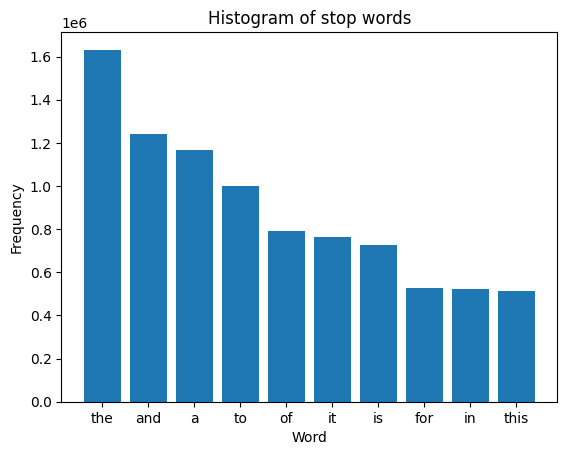

In [ ]:
from collections import defaultdict

corpus=[]

re = data_copy['Text'].str.split()

re =re.values.tolist()

corpus = [word for i in re for word in i]


dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top)
plt.bar(x,y)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Histogram of stop words')
#plt.savefig('my_plot4.png')

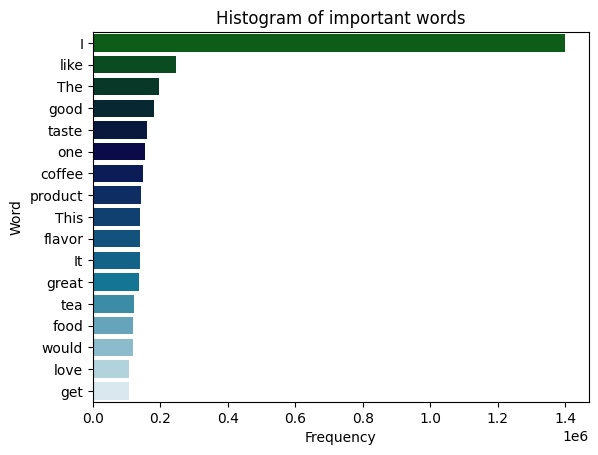

In [ ]:
import seaborn as sns

counter=Counter(corpus)
most=counter.most_common()
x, y=[], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x,palette = 'ocean')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Histogram of important words')
plt.savefig('my_plot5.png')

In [ ]:
df = data_copy

Text(0, 0.5, 'Count')

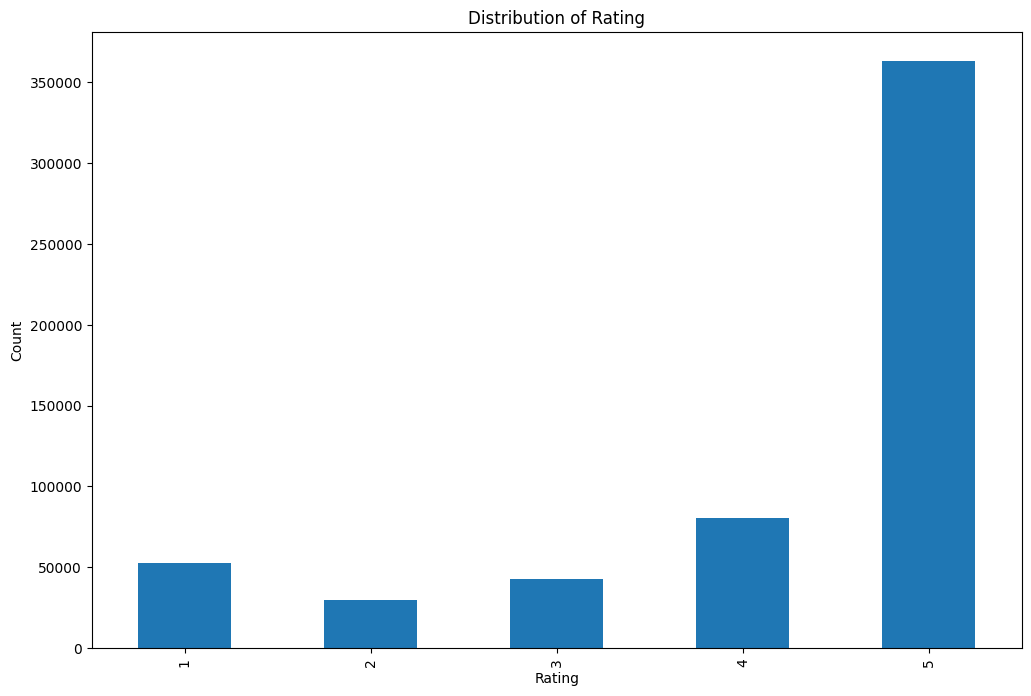

In [ ]:

plt.figure(figsize=(12,8))
df['Score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

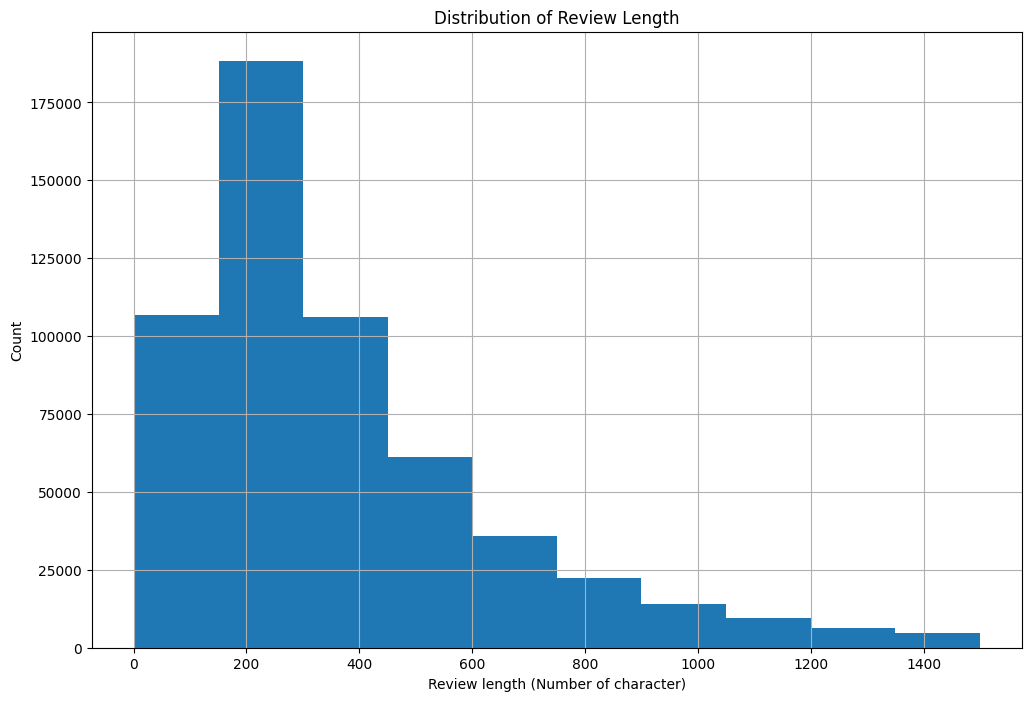

In [ ]:

review_length = df["Text"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

# Data Preprocessing

In [ ]:


df = df.sample(frac=0.1, random_state=0)


df.dropna(inplace=True)


df = df[df['Score'] != 3]


df['Sentiment'] = np.where(df['Score'] < 4, 0, 1)
df.head()

,ProductId,Score,Summary,Text,Sentiment
11214,B001KVPC0G,5,Yes!!!,I could live off of these Im not kidding The r...,1
222079,B000OJ1H36,5,Tropical Trail Mix,I found this product in a local grocery store ...,1
251082,B0009F8JRC,5,Great Gummies!,My young son is taking Chinese in school and w...,1
317731,B005K4Q1RW,5,I'm addicted to this!,I love Grove Square Spiced Apple Cider Cups si...,1
404652,B00153C4B4,2,"Tastes Eh, Very Expensive",This is probably my shortest review but theres...,0


Text(0, 0.5, 'Count')

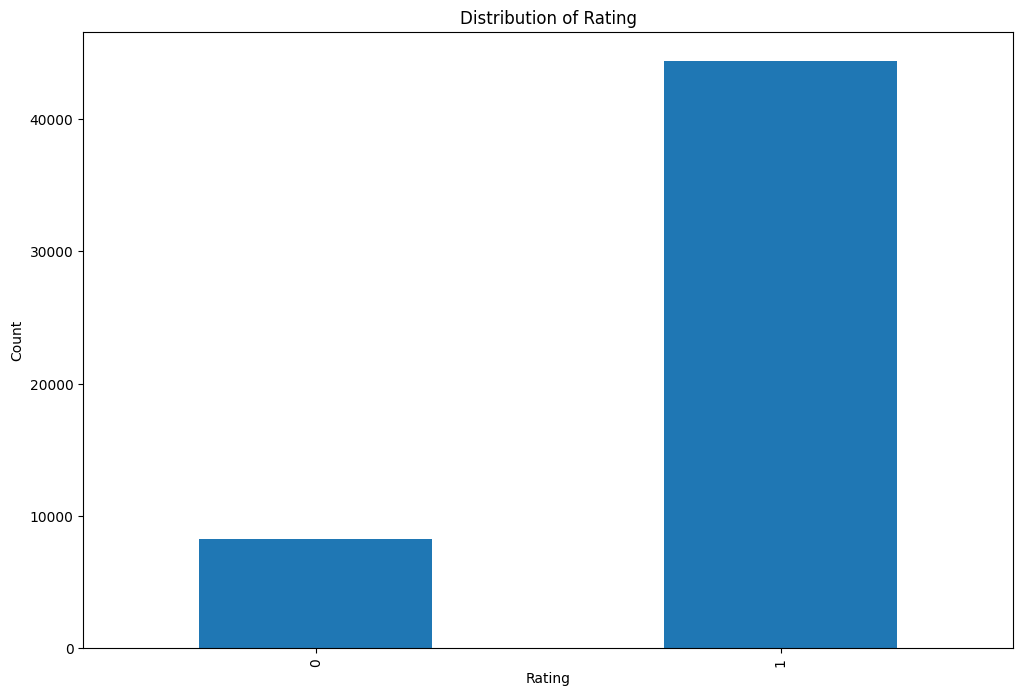

In [ ]:
plt.figure(figsize=(12,8))
df['Sentiment'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

# Splitting Dataset

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'],test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.3, random_state=4)

In [ ]:

import re

def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    words = letters_only.lower().split()

    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    if stemming==True:
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in words]

    if split_text==True:
        return (words)

    return( " ".join(words))

In [ ]:

X_train_cleaned = []
X_val_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))

for d in X_val:
    X_val_cleaned.append(cleanText(d))

for d in X_test:
    X_test_cleaned.append(cleanText(d))

<ipython-input-27-38290a2d15c5>:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()


# Multinomail Naive Bayes Classifier

In [ ]:

countVect = CountVectorizer()
X_train_countVect = countVect.fit_transform(X_train_cleaned)


mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

MultinomialNB()


Accuracy on validation set: 0.8997

AUC score : 0.7181

Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.45      0.59      2511
           1       0.90      0.98      0.94     13286

    accuracy                           0.90     15797
   macro avg       0.87      0.72      0.77     15797
weighted avg       0.90      0.90      0.89     15797


Confusion Matrix : 
 [[ 1135  1376]
 [  209 13077]]
              precision    recall  f1-score       support
0              0.844494  0.452011  0.588846   2511.000000
1              0.904795  0.984269  0.942860  13286.000000
accuracy       0.899664  0.899664  0.899664      0.899664
macro avg      0.874644  0.718140  0.765853  15797.000000
weighted avg   0.895210  0.899664  0.886588  15797.000000
Input Text: The packing was bad, even the food quality was worst
Predicted Sentiment: negative


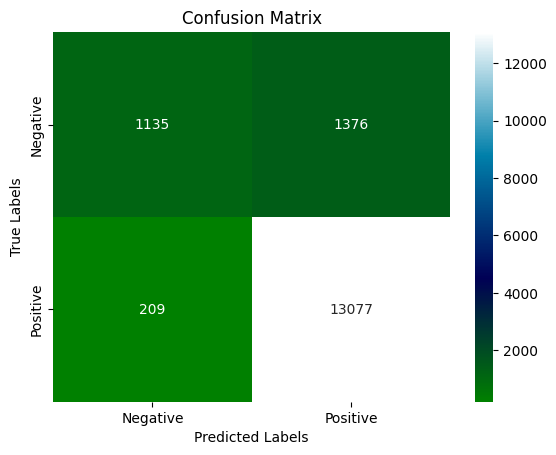

In [ ]:
predictions = mnb.predict(countVect.transform(X_test_cleaned))
reviews=data['Text']
print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))
cm = metrics.confusion_matrix(y_test, predictions)


ax = sns.heatmap(cm, annot=True, cmap="ocean", fmt="d", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])


ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

cr = metrics.classification_report(y_test, predictions, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
print(cr_df)


countVect = CountVectorizer()
X_train_countVect = countVect.fit_transform(X_train_cleaned)


mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

input_text = "The packing was bad, even the food quality was worst"

# Preprocess the input text
input_vector = countVect.transform([input_text])

# Predict sentiment label for the input text
predicted_label = mnb.predict(input_vector)

# Map label to sentiment class
sentiment = "positive" if predicted_label[0] == 1 else "negative"

# Print the predicted sentiment
print("Input Text:", input_text)
print("Predicted Sentiment:", sentiment)


# Logistic Regression

In [ ]:

tfidf = TfidfVectorizer(min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train)
class_weights = {0: 0.67, 1: 0.33}

lr = LogisticRegression(class_weight=class_weights)
lr.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight={0: 0.67, 1: 0.33})

In [ ]:
from sklearn import metrics
predictions = lr.predict(tfidf.transform(X_test_cleaned))

print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))


countVect = CountVectorizer()
X_train_countVect = countVect.fit_transform(X_train_cleaned)

classifier = LogisticRegression()
classifier.fit(X_train_countVect, y_train)
input_text = " I feed stray dogs everyday with this food. Amazing"

input_vector = countVect.transform([input_text])

# Predict sentiment label for the input text
predicted_label = classifier.predict(input_vector)

# Map label to sentiment class
sentiment = "positive" if predicted_label[0] == 1 else "negative"

# Print the predicted sentiment
print("Input Text:", input_text)
print("Predicted Sentiment:", sentiment)



Accuracy on validation set: 0.9107

AUC score : 0.7884

Classification report : 
               precision    recall  f1-score   support

           0       0.78      0.61      0.68      2511
           1       0.93      0.97      0.95     13286

    accuracy                           0.91     15797
   macro avg       0.86      0.79      0.82     15797
weighted avg       0.91      0.91      0.91     15797


Confusion Matrix : 
 [[ 1529   982]
 [  428 12858]]
Input Text:  I feed stray dogs everyday with this food. Amazing
Predicted Sentiment: positive


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(50.722222222222214, 0.5, 'True Labels')

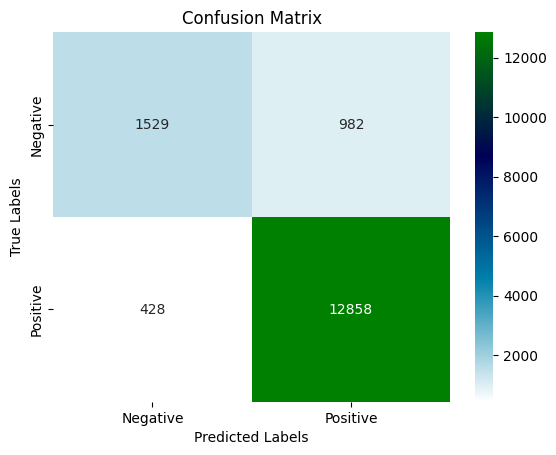

In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)


ax = sns.heatmap(cm, annot=True, cmap="ocean_r", fmt="d", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

In [ ]:
# print classification report
# cr = metrics.classification_report(y_test, predictions, output_dict=True)
# cr_df = pd.DataFrame(cr).transpose()
# print(tabulate(cr_df, headers='keys', tablefmt='psql'))

# LSTM Model

In [ ]:


top_words = 10000
maxlen = 100
batch_size = 256
nb_classes = 2
nb_epoch = 3


tokenizer = Tokenizer(nb_words=top_words)
tokenizer.fit_on_texts(X_train)


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

from keras.utils import pad_sequences
X_train_seq = pad_sequences(sequences_train, maxlen=maxlen)
X_val_seq = pad_sequences(sequences_val, maxlen=maxlen)
X_test_seq = pad_sequences(sequences_test, maxlen=maxlen)


y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_val_seq = np_utils.to_categorical(y_val, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


X_train shape: (25801, 100)
X_test shape: (15797, 100)
y_train shape: (25801, 2)
y_test shape: (15797, 2)


In [ ]:
import gensim.downloader as api


embedding_model = api.load('glove-twitter-100')


embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = embedding_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

[=================================================-] 99.5% 385.2/387.1MB downloaded


In [ ]:
# Construct a simple LSTM
# model1 = Sequential()
# model1.add(Embedding(top_words, 128))
# model1.add(LSTM(128))
# model1.add(Dense(nb_classes))
# model1.add(Activation('softmax'))
# model1.summary()

# model1 = Sequential()
# model1.add(Embedding(top_words, 256))
# model1.add(LSTM(128, return_sequences=True))
# model1.add(LSTM(64, return_sequences=True))
# model1.add(LSTM(32))
# model1.add(Dense(nb_classes))
# model1.add(Activation('softmax'))
# model1.summary()

# model1 = Sequential()
# model1.add(Embedding(10000, 128))
# model1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# model1.add(Dense(2, activation='softmax'))
# model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model1 = Sequential()
# model1.add(Embedding(10000, 128))
# model1.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
# model1.add(Dense(2, activation='softmax'))
# model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1 = Sequential()
model1.add(Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False))
model1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(2, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [ ]:

# history = model1.fit(X_train_seq, y_train_seq, batch_size=256, epochs= 3, validation_data=(X_val_seq, y_val_seq))

checkpoint = ModelCheckpoint("drive/My Drive/Dataset/sentiment_model.hdf5",monitor="val_accuracy",verbose=1,save_best_only=True,mode='auto',period=1,save_weights_only=False)
history = model1.fit(X_train_seq, y_train_seq, batch_size=256, epochs= 5, validation_data=(X_val_seq, y_val_seq),callbacks=[checkpoint])
model1.save("/content/drive/MyDrive/Colab Notebooks/Project")

Epoch 1/5
101/101 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8488
Epoch 1: val_accuracy improved from -inf to 0.85938, saving model to drive/My Drive/Dataset/sentiment_model.hdf5
101/101 [==============================] - 148s 1s/step - loss: 0.3880 - accuracy: 0.8488 - val_loss: 0.3194 - val_accuracy: 0.8594
Epoch 2/5
101/101 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.8721
Epoch 2: val_accuracy improved from 0.85938 to 0.87783, saving model to drive/My Drive/Dataset/sentiment_model.hdf5
101/101 [==============================] - 140s 1s/step - loss: 0.3033 - accuracy: 0.8721 - val_loss: 0.2966 - val_accuracy: 0.8778
Epoch 3/5
101/101 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.8809
Epoch 3: val_accuracy did not improve from 0.87783
101/101 [==============================] - 139s 1s/step - loss: 0.2840 - accuracy: 0.8809 - val_loss: 0.3084 - val_accuracy: 0.8688
Epoch 4/5
101/101 [====================

In [ ]:
model1.evaluate(X_test_seq, y_test_seq, batch_size=256)

62/62 [==============================] - 18s 284ms/step - loss: 0.2425 - accuracy: 0.8983


[0.242513969540596, 0.8982717990875244]

In [ ]:
# model1.save("drive/My Drive/Dataset/trainedsentiments1")

In [ ]:
import pickle as pickle

with open('drive/My Drive/Dataset/SentimentTokenizer.pickle', "wb") as save_tokenizer:
    pickle.dump(tokenizer, save_tokenizer)

# save_tokenizer = open("drive/My Drive/Dataset/SentimentTokenizer.pickle","wb")
# pickle.dump(save_tokenizer,tokenizer)
# save_tokenizer.close();

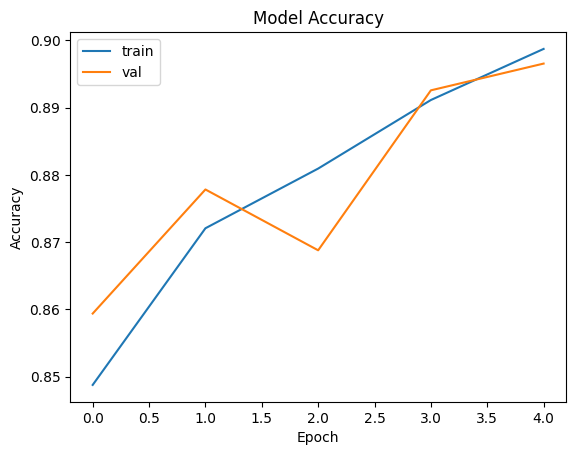

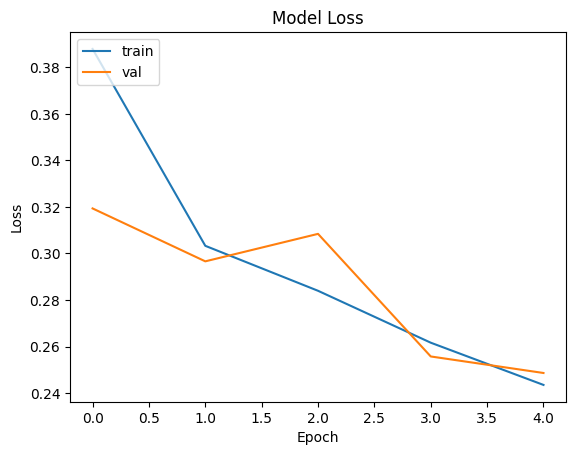

In [ ]:


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Predict.py

import pickle as pickle
from keras.models import load_model

model1 = load_model("drive/My Drive/Dataset/sentiment_model.hdf5")
with open('drive/My Drive/Dataset/SentimentTokenizer.pickle', 'rb') as tokenizer_f :
    tokenizer1 = pickle.load(tokenizer_f )
    model1.summary()
# tokenizer_f = open("drive/My Drive/Dataset/SentimentTokenizer.pickle","rb")
# tokenizer = pickle.load(tokenizer_f)
# tokenizer_f.close();



new_reviews = ["worst food quality"]

for new_review in new_reviews:
    new_review_tokens = tokenizer.texts_to_sequences([new_review])
    new_review_tokens_padded = pad_sequences(new_review_tokens, maxlen=100, padding='post')
    prediction = model1.predict(new_review_tokens_padded)
    sentiment_labels = ['Negative', 'Positive']
    sentiment = sentiment_labels[np.argmax(prediction)]
    print("Prediction:", sentiment)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          5087000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 5,204,506
Trainable params: 117,506
Non-trainable params: 5,087,000
_________________________________________________________________
1/1 [==============================] - 0s 307ms/step
Prediction: Negative
